# Multi class dataset: Wine Quality

##  Preparing the datasets


### Load the Data

In [1]:
import pandas as pd


file_path = "data/winequality-white.csv" 
data = pd.read_csv(file_path, sep=";")

# Preview 
print(data.head())


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

<Axes: >

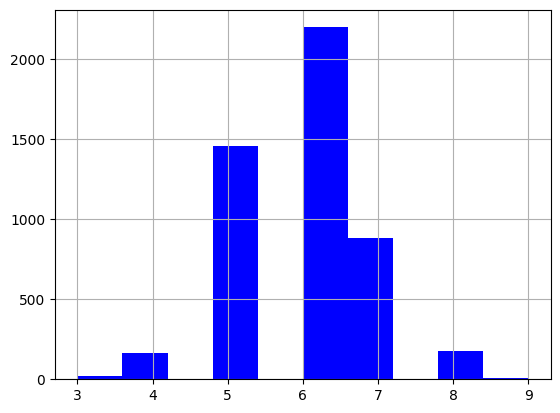

In [2]:
#draw histogram for quality
data['quality'].hist(bins=10, color='blue')

### Preprocess the Data
The dataset doesn't have missing values so we don't need to clean.
No need to convert "quality" column as it is already numeric (0-10)
Separate features and labels.

In [3]:

# Group quality into 3 categories
def categorize_quality(score):
    if score <= 4:
        return 0 #Low
    elif 5 <= score <= 6:
        return 1 #Standard
    else:
        return 2 #High

data["quality"] = data["quality"].apply(categorize_quality)

# Split data into features and labels
features = data.drop(columns=["quality"])  # Features
labels = data["quality"]  # Labels


In [4]:
class_counts = labels.value_counts()
print(class_counts)

quality
1    3655
2    1060
0     183
Name: count, dtype: int64


### Shuffle and Split the Dataset

In [5]:
from sklearn.model_selection import train_test_split

# Splits and stratification
proportions = [40, 60, 80, 90]
splits = {}
for prop in proportions:
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, train_size=prop/100, stratify=labels, random_state=42
    )
    splits[f"{int(prop)}_{int(100-prop)}"] = (X_train, X_test, y_train, y_test)


### Visualize Class Distributions

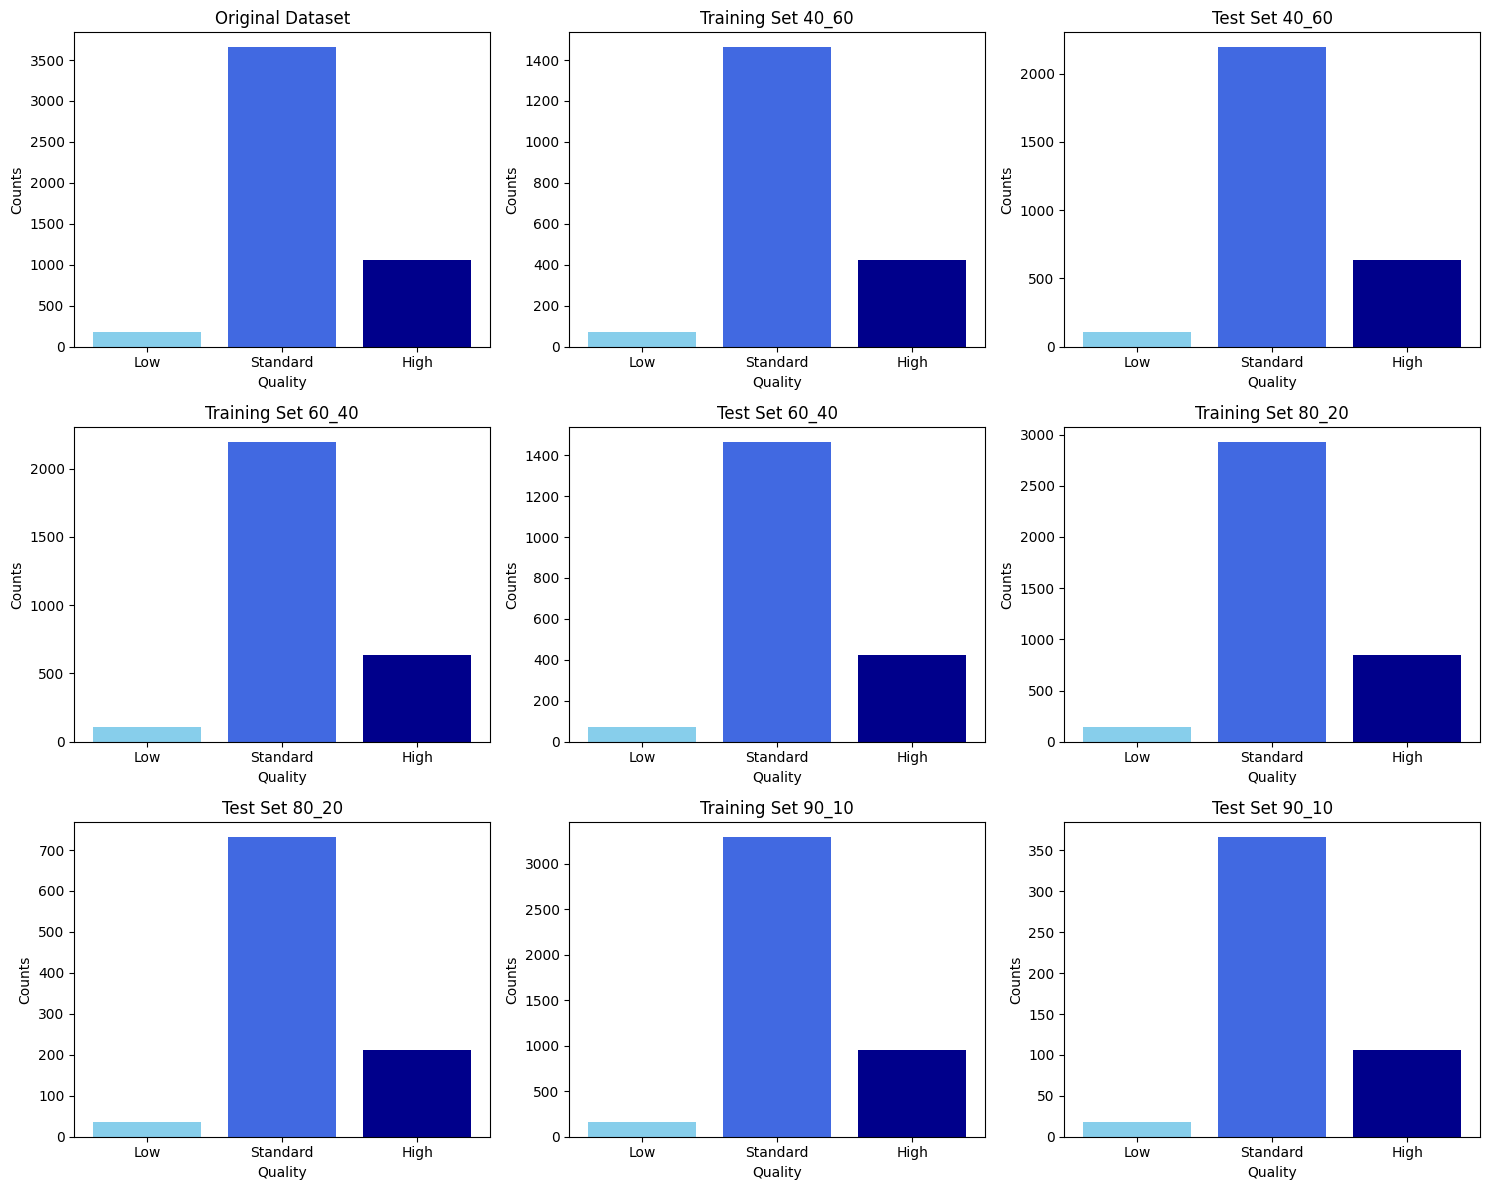

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distribution(ax, title, data_labels):
    unique, counts = np.unique(data_labels, return_counts=True)
    ax.bar(["Low", "Standard", "High"], counts, color=["skyblue", "royalblue", "darkblue"][:len(unique)])
    ax.set_title(title)
    ax.set_xlabel("Quality")
    ax.set_ylabel("Counts")

# Number of splits
num_splits = len(splits)
total_plots = 1 + num_splits * 2  # Original + training + test sets
rows = (total_plots + 2) // 3  
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()

# original dataset
plot_distribution(axes[0], "Original Dataset", labels)

# each split
plot_idx = 1
for key, (X_train, X_test, y_train, y_test) in splits.items():
    plot_distribution(axes[plot_idx], f"Training Set {key}", y_train)
    plot_idx += 1
    plot_distribution(axes[plot_idx], f"Test Set {key}", y_test)
    plot_idx += 1

# Hide any unused subplots
for i in range(plot_idx, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


## Building the decision tree classifiers

Classification Report for Split 40_60:
                  precision    recall  f1-score   support

     Low quality       0.26      0.22      0.24       110
Standard quality       0.84      0.84      0.84      2193
    High quality       0.55      0.58      0.57       636

        accuracy                           0.76      2939
       macro avg       0.55      0.55      0.55      2939
    weighted avg       0.76      0.76      0.76      2939



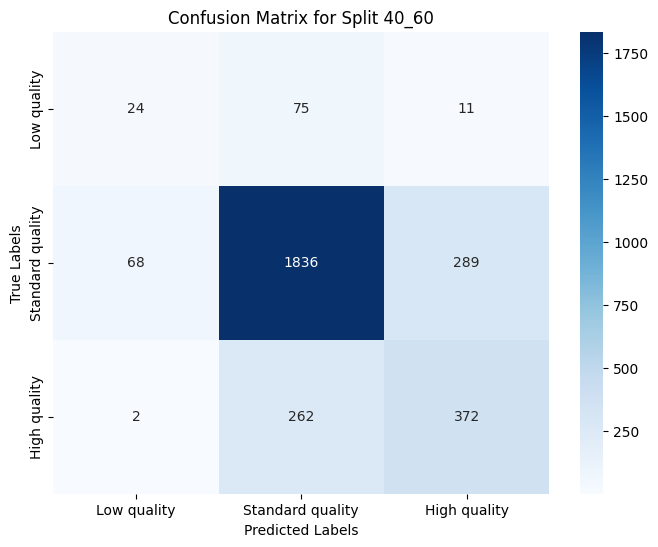

Classification Report for Split 60_40:
                  precision    recall  f1-score   support

     Low quality       0.25      0.27      0.26        73
Standard quality       0.85      0.84      0.85      1463
    High quality       0.58      0.59      0.59       424

        accuracy                           0.77      1960
       macro avg       0.56      0.57      0.56      1960
    weighted avg       0.77      0.77      0.77      1960



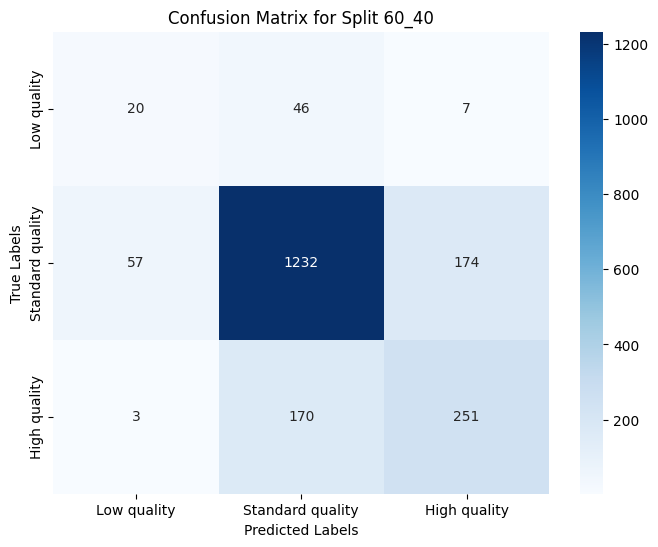

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.831439 to fit


Classification Report for Split 80_20:
                  precision    recall  f1-score   support

     Low quality       0.31      0.38      0.34        37
Standard quality       0.87      0.85      0.86       731
    High quality       0.62      0.63      0.63       212

        accuracy                           0.79       980
       macro avg       0.60      0.62      0.61       980
    weighted avg       0.79      0.79      0.79       980



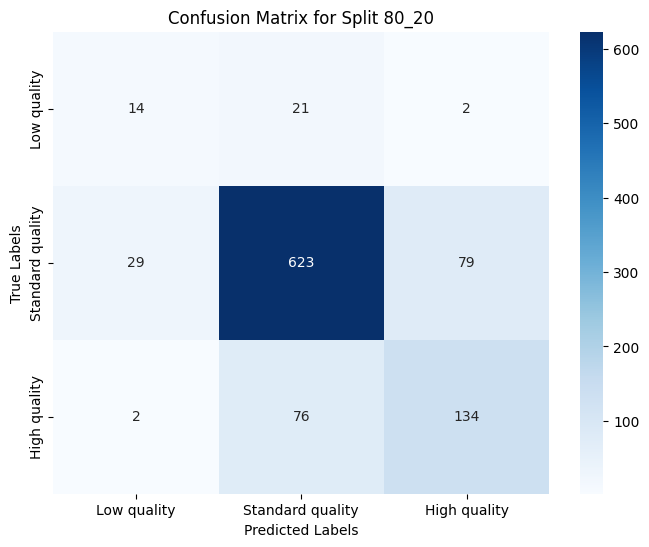

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.745501 to fit


Classification Report for Split 90_10:
                  precision    recall  f1-score   support

     Low quality       0.32      0.44      0.37        18
Standard quality       0.89      0.83      0.85       366
    High quality       0.60      0.71      0.65       106

        accuracy                           0.79       490
       macro avg       0.60      0.66      0.63       490
    weighted avg       0.80      0.79      0.79       490



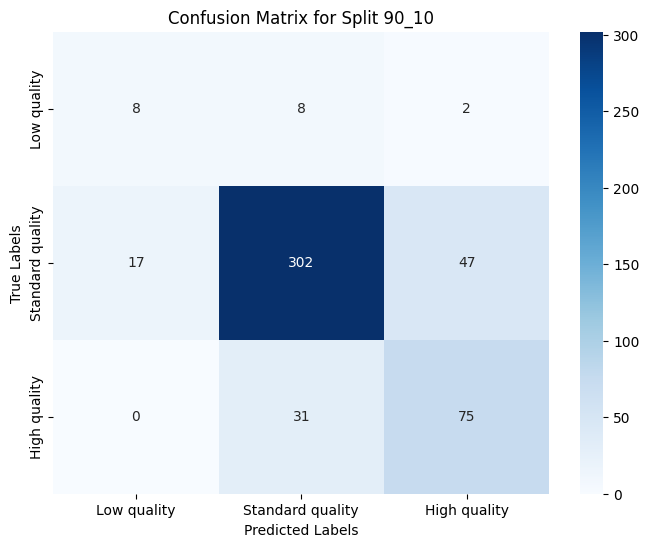

In [7]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

for key, (X_train, X_test, y_train, y_test) in splits.items():
    clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
    clf.fit(X_train, y_train)
    
    # Export 
    dot_data = export_graphviz(
        clf, 
        out_file=None,  
        feature_names=data.drop(columns=["quality"]).columns, 
        class_names=["Low quality", "Standard quality", "High quality"], 
        filled=True, 
        rounded=True, 
        special_characters=True
    )

    graph = graphviz.Source(dot_data)
    graph.render(f"plots/dataset2/decision_tree_{key}", format="png")
    #print(f"Decision Tree Graph for Split {key}:")
    #display(graph)  

    # Generate classification report
    y_pred = clf.predict(X_test)
    print(f"Classification Report for Split {key}:")
    print(classification_report(y_test, y_pred, target_names=["Low quality", "Standard quality", "High quality"]))

    # Generate and display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Low quality", "Standard quality", "High quality"], 
                yticklabels=["Low quality", "Standard quality", "High quality"])
    plt.title(f"Confusion Matrix for Split {key}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


## The depth and accuracy of a decision tree

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.831439 to fit


Decision Tree Graph for Max Depth None:
Decision Tree Graph for Max Depth 2:
Decision Tree Graph for Max Depth 3:
Decision Tree Graph for Max Depth 4:
Decision Tree Graph for Max Depth 5:
Decision Tree Graph for Max Depth 6:
Decision Tree Graph for Max Depth 7:
Max Depth Accuracy
None      0.7867
2         0.7459
3         0.7582
4         0.7571
5         0.7786
6         0.7653
7         0.7745


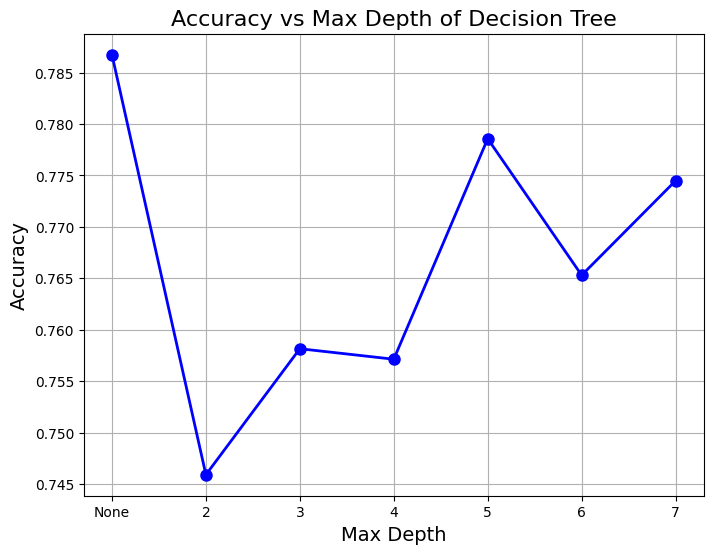

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
import graphviz

# Train and evaluate decision trees for max_depth values: None, 2, 3, 4, 5, 6, 7
max_depth_values = [None, 2, 3, 4, 5, 6, 7]
accuracy_scores = []

# Prepare data (use 80/20 split)
X_train, X_test, y_train, y_test = splits["80_20"]

for max_depth in max_depth_values:
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
    # Export
    dot_data = export_graphviz(
        clf, 
        out_file=None,  
        feature_names=data.drop(columns=["quality"]).columns, 
        class_names=["Low quality", "Standard quality", "High quality"],
        filled=True,  
        rounded=True,  
        special_characters=True
    )

    graph = graphviz.Source(dot_data)
    graph.render(f"plots/dataset2/decision_tree_max_depth_{max_depth}", format="png") 

# Report the accuracy scores in a formatted table
print(f"{'Max Depth':<10}{'Accuracy'}")
for depth, accuracy in zip(max_depth_values, accuracy_scores):
    depth_str = "None" if depth is None else depth
    print(f"{depth_str:<10}{accuracy:.4f}")

# Plot the accuracy vs max_depth
plt.figure(figsize=(8, 6))
plt.plot([str(d) if d is not None else "None" for d in max_depth_values], accuracy_scores, 
         marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.title("Accuracy vs Max Depth of Decision Tree", fontsize=16)
plt.xlabel("Max Depth", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True)
plt.show()
